In [4]:
import numpy as np
import pandas as pd
from glob import glob


import math
from statistics import mean 
from scipy import stats
from skbio.stats import subsample_counts

import seaborn as sns
import matplotlib.pyplot as plt

# GOAL: Make rarefaction curves to look at specific phyla instead of the whole community
## METHOD: Split the OTU tab up by phyla groups and then add a "dummy" otu to to represent the rest of the community

In [3]:
otu_tab=pd.read_csv("otu_tabs/combined_reps_with_metadata.txt",sep='\t')

grouping_list=[]
for index, row in otu_tab.iterrows():
    if row['treatment']=="nLY":
        grouping_list.append("Lysozyme -")
    elif row['treatment']=="yLY":
        grouping_list.append("Lysozyme +")
    elif row['group']=="Nycodenz":
        grouping_list.append("Nycodenz")
otu_tab["group"]=grouping_list
otu_tab=otu_tab[otu_tab["Donor"]!="UH02"]

otu_tab.head(2)

,Unnamed: 0,Donor,exp,group,sub_group,treatment,sequence_group,otu1,otu10,otu100,...,otu988,otu99,otu990,otu991,otu993,otu995,otu996,otu997,otu998,otu999
0,0,UC02,HtDnLy,Lysozyme -,nDN,nLY,3,0.0,0.0,530.0,...,0.0,428.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,UC02,HtDnLy,Lysozyme +,nDN,yLY,3,5.0,1.0,489.0,...,5.0,445.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


### Split the tabl up by donor and filter empty otus

In [9]:
def filter_zero_otus(filter_df, min_detect, threshold):
    detect_list_out=[]

    this_df=filter_df.copy()
    this_df=this_df[[col for col in this_df.columns if col.startswith('otu')]].T
    #    min_detect=1*len(this_df.columns)
    detect_list=[]
    for row in this_df.iterrows():
        total=0
        for x in row[1].to_list():
            if x >= threshold:
                total=total+1
        detect_list.append(total)


    this_df['detect']=detect_list
    this_df=this_df[this_df['detect']>=min_detect]
    this_df=this_df.drop(['detect'], axis=1)
    return this_df.T


#Split by donor and remove zeros
payload=[]
for donor, group in otu_tab.groupby("Donor"):
    meta_cols=[col for col in group.columns if not col.startswith('otu')]
    df_filtered=filter_zero_otus(group,1,1)
    print(df_filtered.shape)
    df_filtered = pd.concat([group[meta_cols],df_filtered], axis=1)   
    payload.append(df_filtered.drop(["Unnamed: 0"],axis=1))
    print(df_filtered.drop(["Unnamed: 0"],axis=1).shape)

#shuffle
x=payload[1]
payload[1]=payload[0]
payload[0]=x

(12, 951)
(12, 957)
(14, 337)
(14, 343)


### Group the tabs by phylum before adding a new otu to represent the rest of the community
### The export the files for processing in qiime1

In [18]:
taxa_df=pd.read_csv("all_taxonomy_split.txt",sep='\t').drop(["Unnamed: 0"], axis=1).set_index("featureid")
taxa_df.head(2)

,taxonomy,kingdom,phylum,class,order,family,genus,species
featureid,,,,,,,,
otu1,Bacteria(100);Bacteroidetes(100);Bacteroidia(1...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,NaN
otu2,Bacteria(100);Bacteroidetes(100);Bacteroidia(1...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella_9,NaN


In [94]:
donor_names=["human","chicken"]
for i in range(2):
    df=payload[i].copy()
    o_cols=df[[col for col in df.columns if col.startswith('otu')]].T

    col_names=o_cols.columns
    o_cols=pd.merge(taxa_df["phylum"], o_cols, left_index=True, right_index=True, how="right")
    o_cols.head(2)

    sample_totals=o_cols[col_names].sum(axis=0)
    for phylum, group in o_cols.groupby("phylum"):
        group2=group.drop(["phylum"],axis=1)
        group2=group2.T
        phy_sum=group2.sum(axis=1)
        group2["others"]=sample_totals-phy_sum
        group2=group2.T
        group2.index.name="OTU ID#"
        group2.to_csv("phylum_split_otu_tabs/raw_tabs/"+donor_names[i]+"_"+phylum+"_split_otu_tab.txt",sep='\t')
        


# QIIME1 Overview
* Exported tabs are converted to biom files for qiime using "biom convert"
* Rarefied biom files are made using "multiple_rarefactions.py -i in.biom -m 10 -x 130000 -s 100 -n 5 -k -o out.biom"
    * min 10, max 130,000, 5 replicates, step by 100
* Count otus for each table using "alpha_diversity.py -i in -m observed_otus -o out"
* Combine all the otu counts into one file using "collate_alpha.py "

# Now I import the output in for graphing and analysis

In [316]:
human_files=glob("phylum_split_otu_tabs/4summarize_features_observed/human*/observed_otus.txt")
chicken_files=glob("phylum_split_otu_tabs/4summarize_features_observed/chicken*/observed_otus.txt")

In [317]:
in_load={}
for file in human_files:
    in_df=pd.read_csv(file, sep='\t').drop(["Unnamed: 0","iteration"],axis=1)
    in_df.columns=["sequences per sample", "n_lyse","y_lyse","n_lyse","y_lyse","n_lyse","y_lyse","n_lyse","y_lyse","nyco","nyco","nyco","nyco","nyco","nyco"]
    the_key=file.split("/")[2].rsplit("_",3)[0]  #dig out the donor and phylum name from the file
    in_load[the_key]=in_df
for file in chicken_files:
    in_df=pd.read_csv(file, sep='\t').drop(["Unnamed: 0","iteration"],axis=1)
    in_df.columns=["sequences per sample", "n_lyse","y_lyse","n_lyse","y_lyse","n_lyse","y_lyse","n_lyse","y_lyse","nycoo","nyco","nyco","nyco"]
    the_key=file.split("/")[2].rsplit("_",3)[0]  #dig out the donor and phylum name from the file
    in_load[the_key]=in_df

In [327]:
#I need to trim all the replicates to the same depth 
truncate_load={}
for key, df in in_load.items():
    y_half=df["y_lyse"].dropna()
    n_half=df["n_lyse"].dropna()
    combine=pd.concat([y_half,n_half], axis=1)
    combine["sequences per sample"]=df["sequences per sample"][:len(combine.index)]
    truncate_load[key]=combine

In [328]:
truncate_load["chicken_Cyanobacteria"]

,y_lyse,y_lyse,y_lyse,y_lyse,n_lyse,n_lyse,n_lyse,n_lyse,sequences per sample
0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,10
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10
3,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,10
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10
...,...,...,...,...,...,...,...,...,...
5205,17.0,17.0,14.0,15.0,NaN,NaN,NaN,NaN,104110
5206,16.0,17.0,14.0,15.0,NaN,NaN,NaN,NaN,104110
5207,17.0,17.0,14.0,15.0,NaN,NaN,NaN,NaN,104110
5208,17.0,17.0,14.0,15.0,NaN,NaN,NaN,NaN,104110


In [382]:
melt_load={}
stat_load={}
ks_load={}
for key, df in truncate_load.items():
    #format the data for graphing
#    df_mean=df.dropna()
    df_mean= df.groupby(["sequences per sample"]).mean()
 #   This was to calculate the KS statistic but it's not really useful
 #   yes_mean=df_mean["y_lyse"].mean(axis=1)
 #   no_mean=df_mean["n_lyse"].mean(axis=1)
 #   meanOFmeans=pd.concat([yes_mean,no_mean],axis=1).dropna()
 #   meanOFmeans.columns=["y_lyse","n_lyse"]
 #   stats.ks_2samp(meanOFmeans["y_lyse"], meanOFmeans["n_lyse"])
    
    df_mean["sequences per sample"]=df_mean.index
    df_melt = pd.melt(df_mean, id_vars=["sequences per sample"], value_vars=["n_lyse","y_lyse"])
       
    melt_load[key]=df_melt
    
    #perform t-test for significant differences
    out_list=[]
    test_group = df_melt.groupby(["sequences per sample"])
    for depth, group in test_group:
        yes=group[group["variable"]=="y_lyse"]
        no=group[group["variable"]=="n_lyse"]
        sStat, spVal = stats.ttest_ind(yes["value"], no["value"])       #standard 2-sided t-test
        wStat, wpVal = stats.ttest_ind(yes["value"], no["value"], equal_var=False)  #welch's t-test
        out_list.append([depth, sStat, spVal, wStat, wpVal])
        
    out_df=pd.DataFrame(out_list, columns=["depth","student_tScore","student_pVal", "welch_tScore", "welch_pVal"]).dropna(axis="rows")
    student_correct = multipletests(out_df["student_pVal"], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
    welch_correct = multipletests(out_df["welch_pVal"], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
    out_df["student_correct"]=student_correct[1]
    out_df["welch_correct"]=welch_correct[1]
    stat_load[key]=out_df
    

In [407]:
df_mean

,y_lyse,y_lyse,y_lyse,y_lyse,n_lyse,n_lyse,n_lyse,n_lyse,sequences per sample
sequences per sample,,,,,,,,,
10,3.4,4.0,3.8,3.6,3.8,2.8,3.2,3.6,10
110,27.4,29.8,29.0,30.2,25.6,24.2,26.8,25.6,110
210,50.2,50.6,46.8,50.8,36.2,40.6,36.8,39.4,210
310,63.8,61.6,57.4,61.4,52.8,57.0,47.8,53.6,310
410,75.2,79.6,71.8,73.6,63.6,66.8,58.8,70.0,410
...,...,...,...,...,...,...,...,...,...
103710,456.8,465.6,465.8,458.8,NaN,NaN,NaN,NaN,103710
103810,456.0,464.8,466.0,455.2,NaN,NaN,NaN,NaN,103810
103910,455.0,464.6,466.0,457.6,NaN,NaN,NaN,NaN,103910


## I have to decide where to mark significant differences in the rarefaction
### Ill use a sliding window with the mean to check for passing threshold and produce a vector for each depth. 
### I'll use the end of the largets continous region of passing values

In [383]:
#I'm only looking at the signigicant ones now
sig_keys=["human_Firmicutes","chicken_Firmicutes","chicken_Bacteroidetes"]
sliding_average={}
window=10
for a_key in sig_keys:
    this_df=stat_load[a_key].copy()
    mean_list=[0,0,0,0,0,0,0,0,0,0] #This should be made from the window size but I didn;t figure it out
    p_vals=this_df["welch_correct"]
    #go though and calculate using the sliding window
    for i in range(window,len(p_vals)):
        mean_p=mean(p_vals[i-window:i])
        if mean_p <= 0.05:
            mean_list.append(1)
        else:
            mean_list.append(0)
 #   window_df = pd.concat([p_vals, pd.Series(mean_list)], axis=1)
    this_df["10_window_pass"]=mean_list
    sliding_average[a_key]=this_df

In [388]:
this_df.head()

,depth,student_tScore,student_pVal,welch_tScore,welch_pVal,student_correct,welch_correct,10_window_pass
0,10,0.534522,0.612197,0.534522,0.618188,0.625878,0.633417,0
1,110,0.536107,0.611167,0.536107,0.624437,0.625523,0.638391,0
2,210,1.322723,0.234105,1.322723,0.263866,0.249658,0.281067,0
3,310,0.499139,0.635451,0.499139,0.639268,0.647481,0.651370,0
4,410,-1.166667,0.287613,-1.166667,0.287790,0.303886,0.304425,0


<img src="darjeeling-1.png">

### https://github.com/karthik/wesanderson/blob/master/figure/darjeeling-1.png

In [403]:
Darjeeling1_pallet=['#ff2500','#01a08a','#f2ad00','#f98400','#5bbcd6']

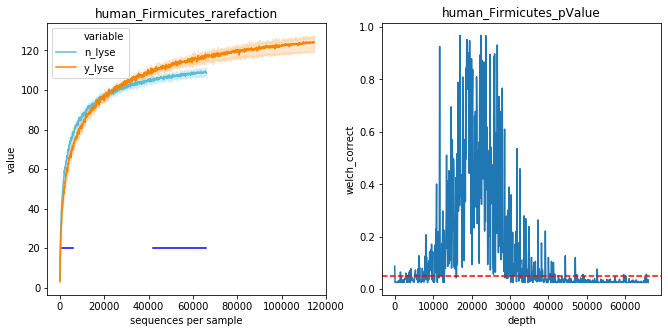

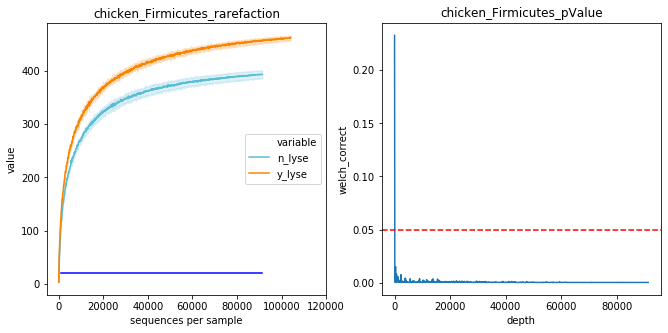

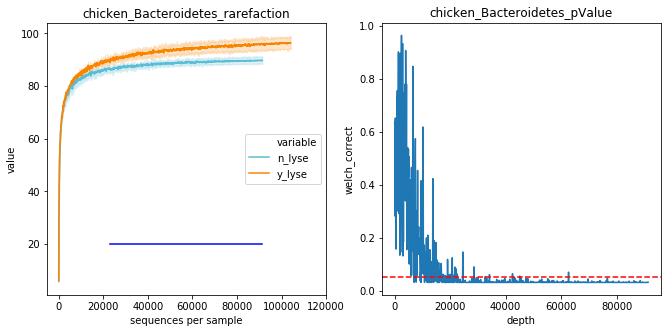

In [408]:
#set the vaues that will graph significant regions of difference
sig_graph_dict={"human_Firmicutes": [1010,6110,41910,66010],"chicken_Firmicutes":[0,0,1010,91410],"chicken_Bacteroidetes":[0,0,22910,91410]}
plt.rcParams['svg.fonttype'] = 'none'
sub_pallet=[Darjeeling1_pallet[4],Darjeeling1_pallet[3]]
for key in sig_keys:
    df= sliding_average[key]
    f, axes = plt.subplots(1,2, figsize=(11,5),squeeze=False)
    sns.lineplot(x="depth", y="welch_correct",data=df, ax=axes[0][1])
    axes[0][1].axhline(0.05, color='r', ls='--')
    axes[0][1].set_title(key+"_pValue")
    
    sig_coords=sig_graph_dict[key]
    axes[0][0].plot([sig_coords[2],sig_coords[3]], [20,20], color='b')
    axes[0][0].plot([sig_coords[0],sig_coords[1]], [20,20], color='b')
    sns.lineplot(x="sequences per sample", y="value", hue="variable",data=melt_load[key], ax=axes[0][0], palette=sub_pallet).set_title(key+"_rarefaction")
    axes[0][0].set_xlim(right=120000)
  #  axes[0][0].axhline(y=1, xmin=sig_coords[0], xmax=sig_coords[1], linewidth=8)
  #  axes[0][0].axhline(y=1, xmin=sig_coords[2], xmax=sig_coords[3], linewidth=8)
    plt.savefig("phylum_split_otu_tabs/5rare_curvs/"+key+"_welch_sig_marked_altColor.svg", type="svg")

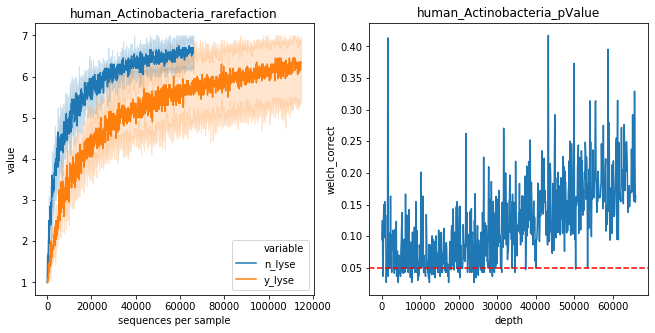

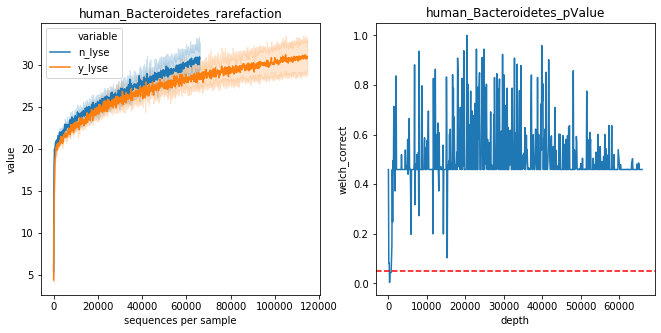

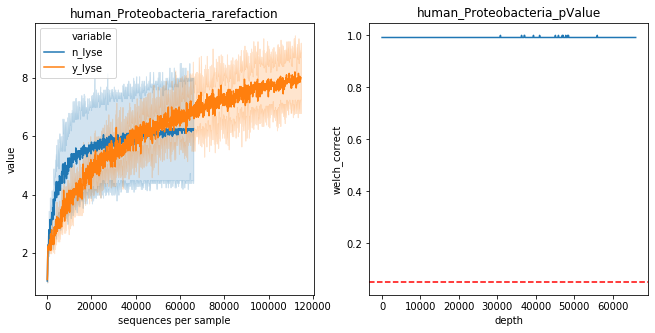

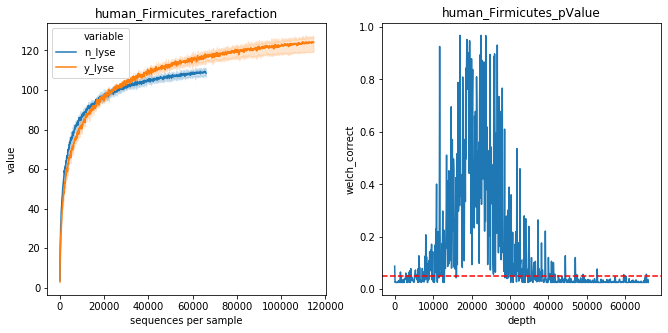

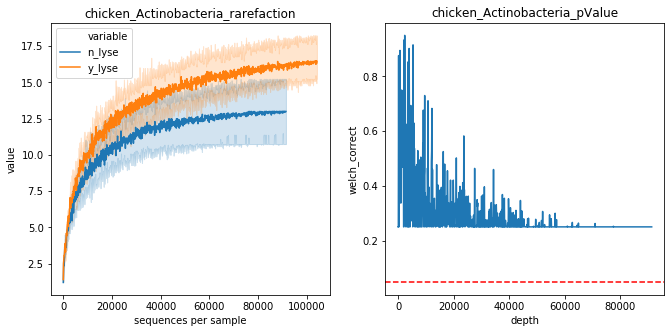

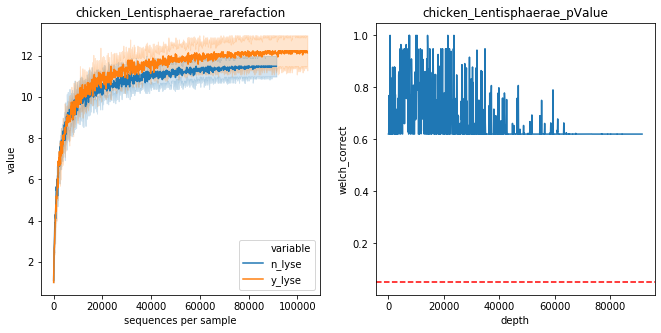

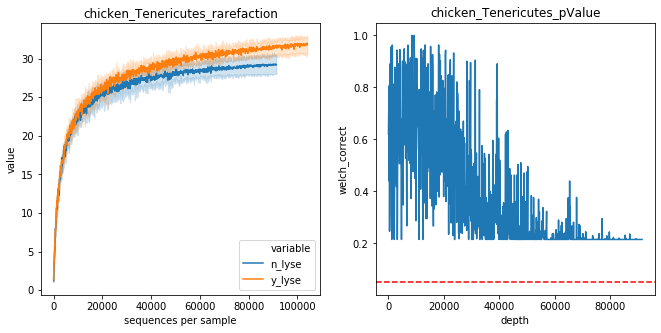

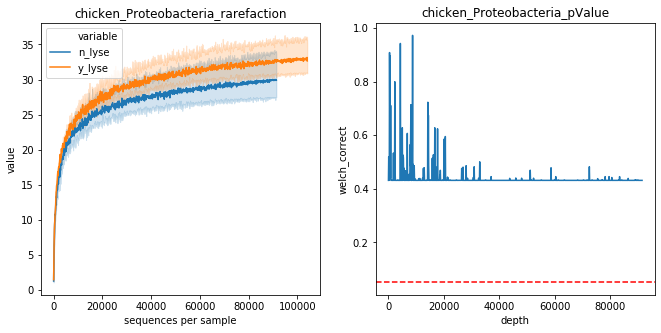

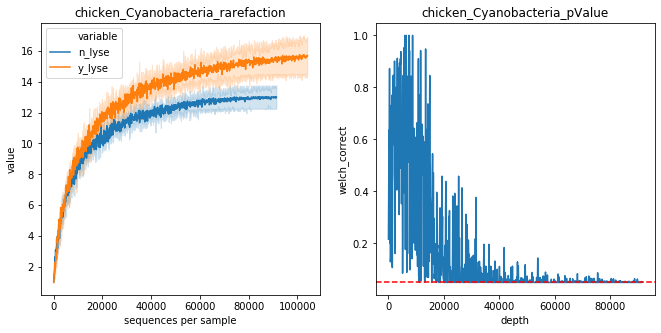

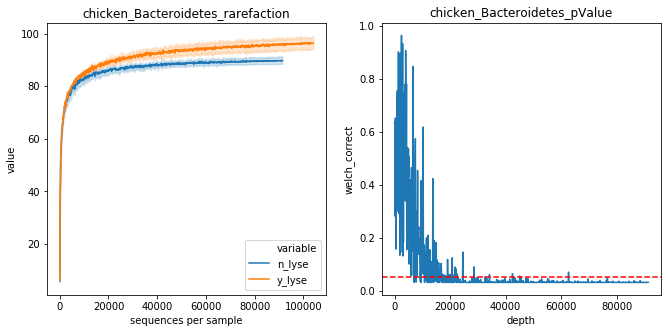

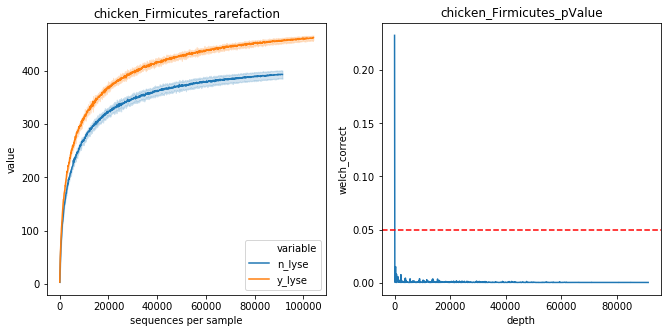

In [330]:


for key, df in stat_load.items():
    f, axes = plt.subplots(1,2, figsize=(11,5),squeeze=False)
    sns.lineplot(x="depth", y="welch_correct",data=df, ax=axes[0][1])
    axes[0][1].axhline(0.05, color='r', ls='--')
    axes[0][1].set_title(key+"_pValue")

    sns.lineplot(x="sequences per sample", y="value", hue="variable",data=melt_load[key], ax=axes[0][0]).set_title(key+"_rarefaction")


    plt.savefig("phylum_split_otu_tabs/5rare_curvs/"+key+"_welch_corrected.svg", type="svg")

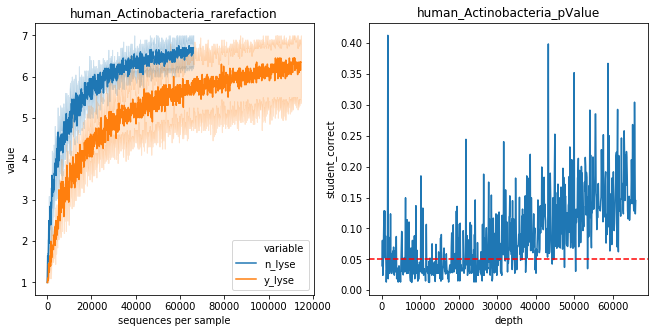

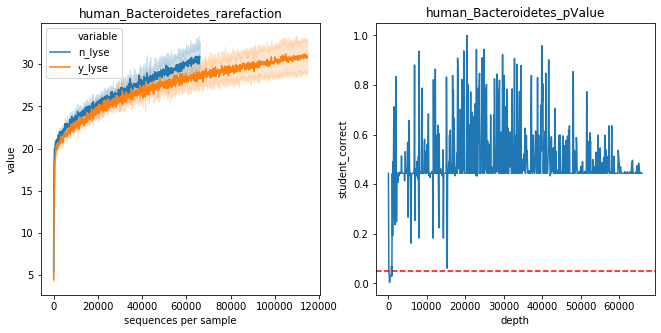

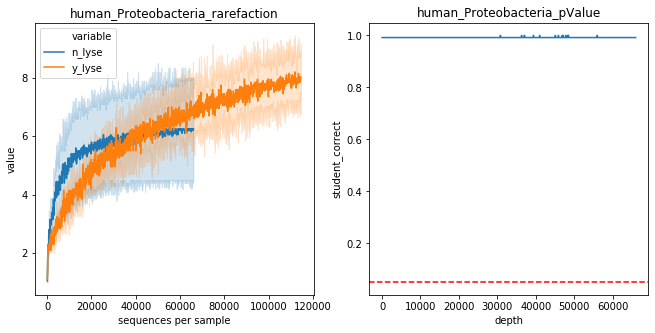

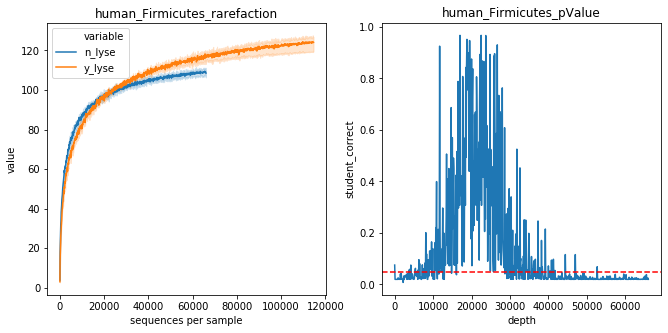

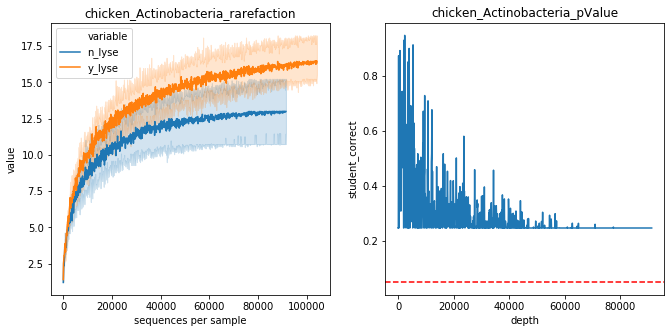

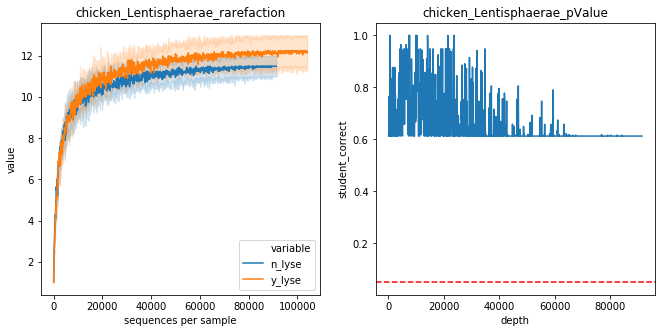

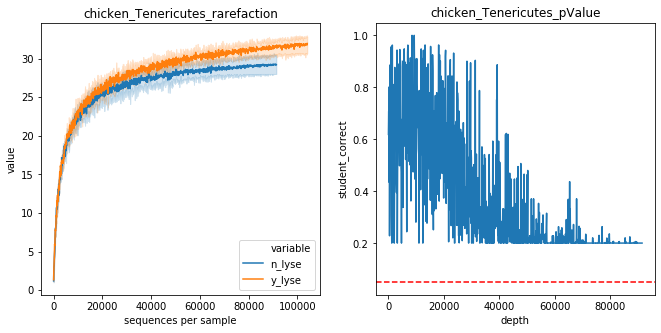

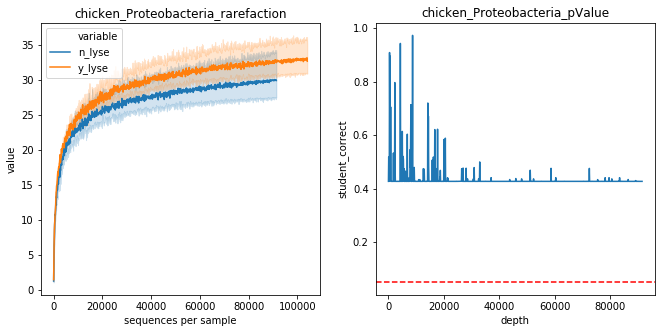

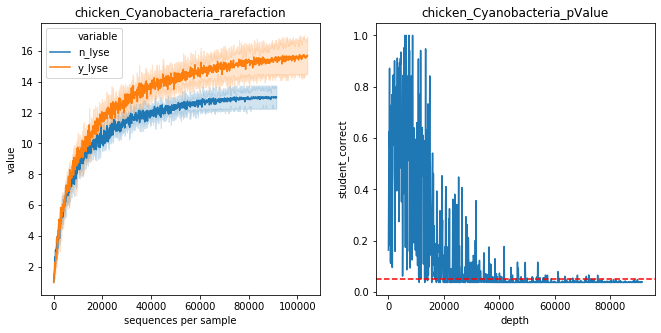

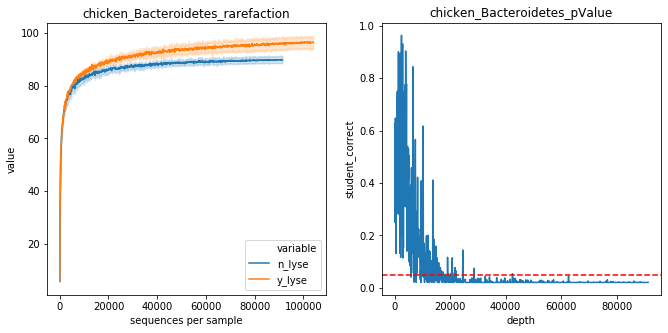

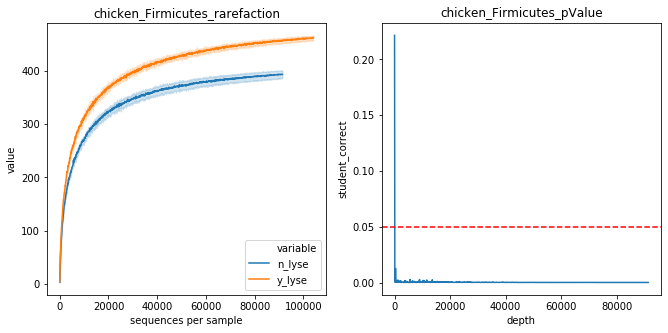

In [331]:


for key, df in stat_load.items():
    f, axes = plt.subplots(1,2, figsize=(11,5),squeeze=False)
    sns.lineplot(x="depth", y="student_correct",data=df, ax=axes[0][1])
    axes[0][1].axhline(0.05, color='r', ls='--')
    axes[0][1].set_title(key+"_pValue")

    sns.lineplot(x="sequences per sample", y="value", hue="variable",data=melt_load[key], ax=axes[0][0]).set_title(key+"_rarefaction")


    plt.savefig("phylum_split_otu_tabs/5rare_curvs/"+key+"_student_corrected.svg", type="svg")

In [ ]:
ax = sns.lineplot(x="sequences per sample", y="value", hue="variable",
                  data=melt_again)

In [ ]:
out_list=[]
test_group = melt_again.groupby(["sequences per sample"])
for depth, group in test_group:
    yes=group[group["variable"]=="y_lyse"]
    no=group[group["variable"]=="n_lyse"]
    tStat, pVal = stats.ttest_ind(yes["value"], no["value"])
    out_list.append([depth, tStat, pVal])

In [ ]:
out_dfff=pd.DataFrame(out_list, columns=["depth","tScore","pVal"])
ax = sns.lineplot(x="depth", y="pVal",
                  data=out_dfff)

In [ ]:
out_dfff.to_csv("trial_pVals.txt",sep='\t')